In [1]:
import numpy as np
from scipy.stats import special_ortho_group
import jax.numpy as jnp
from jax import grad, vmap
from Mondrian_forest import *
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import pickle

dim_in = 5
active = 2
def simulate_y(x, rotation, seed = 0, noise_sig2 = 0.01):
    res = jnp.dot(x, rotation)
    res = (res ** 2) * -0.25
    res = jnp.exp(res)
    projected = jnp.concatenate([jnp.ones(active), jnp.zeros(dim_in - active)])
    y = 5 * jnp.max(res * projected, axis = 1)
    r_noise = np.random.RandomState(seed)
    #n = len(x)
    noise = r_noise.randn(1)[0] * jnp.sqrt(noise_sig2)
    y = y + noise
    return y


n = 2000
n_test = 1000
tries = 10


x_train, _, x_test, _, _ = pickle.load(open('axis_aligned_data.pickle', 'rb'))

x_train = x_train[:, :dim_in]
x_test = x_test[:, :dim_in]

rotation = np.identity(dim_in)
rotation[1,0] = 1
rotation[2,0] = 1
rotation[3,1] = rotation[4,1] = 1

y_train = simulate_y(x_train, rotation)

y_test = simulate_y(x_test, rotation)

sample_range = [100, 200, 400, 800, 1600]

M = 10                      # number of Mondrian trees to use
delta = 0                   # ridge regression delta

rotation

array([[1., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0.],
       [1., 0., 1., 0., 0.],
       [0., 1., 0., 1., 0.],
       [0., 1., 0., 0., 1.]])

In [2]:
def simulate_y(x, rotation, seed = 0, noise_sig2 = 0.01):
    res = jnp.dot(x, rotation)
    res = (res ** 2) * -0.25
    res = jnp.exp(res)
    projected = jnp.concatenate([jnp.ones(active), jnp.zeros(dim_in - active)])
    y = 5 * jnp.max(res * projected)
    r_noise = np.random.RandomState(seed)
    #n = len(x)
    noise = r_noise.randn(1)[0] * jnp.sqrt(noise_sig2)
    y = y + noise
    return y
W_grad = vmap(grad(simulate_y, argnums=0), in_axes=(0, None), out_axes=0)(x_test, rotation)
from numpy import linalg
true_H = jnp.matmul(jnp.transpose(W_grad), W_grad) / n_test
norm_H = linalg.norm(true_H, ord = 2)

In [3]:
np.set_printoptions(precision=5, suppress=True)
true_H/two_one_norm(true_H)

Array([[0.52338, 0.52338, 0.52338, 0.     , 0.     ],
       [0.52338, 1.02491, 0.52338, 0.50153, 0.50153],
       [0.52338, 0.52338, 0.52338, 0.     , 0.     ],
       [0.     , 0.50153, 0.     , 0.50153, 0.50153],
       [0.     , 0.50153, 0.     , 0.50153, 0.50153]], dtype=float32)

In [4]:
np.linalg.matrix_rank(true_H)

2

# Save training history

In [5]:
lifetime = 5

stats = []
for i in range(len(sample_range)):
    n_sim = sample_range[i]
    dist = {'n': n_sim, 'history': []}
    for trial in tqdm(range(tries)):
        history, w_trees = train(
            x_train[:n_sim, ], y_train[:n_sim, ], M, lifetime, delta
        )
        dist['history'].append([history, w_trees])
    stats.append(dist)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:17<00:00,  1.71s/it]


# Get H estimate

In [6]:
from estimate_H import *
raw_H_estimates = get_H_estimates(stats, x_train, y_train, M, sample_range, tries = 10)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:28<00:00,  8.88s/it]


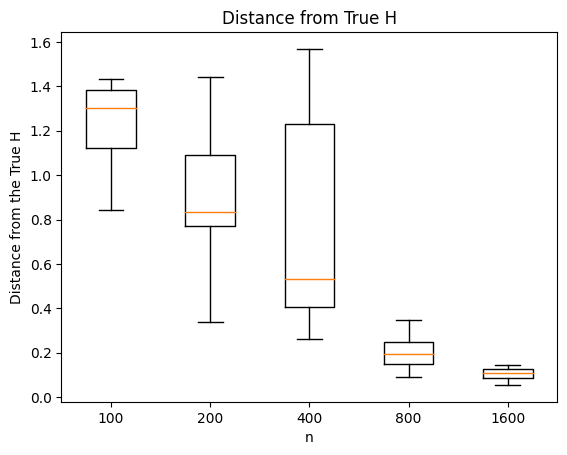

In [7]:
from util import *
np.set_printoptions(precision=4)
plot_H_estimates(raw_H_estimates, true_H, get_angle_distance, sample_range, active, dim_in)

In [8]:
lifetime_max = 5
n_sim = 1600
results = []
results.append(
    evaluate_all_lifetimes(x_train[:n_sim,], 
                           y_train[:n_sim], 
                           x_test, y_test, M, lifetime_max, delta))

In [9]:
x_train_transformed, x_test_transformed = transform_data(true_H/two_one_norm(true_H), x_train, x_test)
results.append(
    evaluate_all_lifetimes(x_train_transformed[:n_sim, ], 
                           y_train[:n_sim], 
                           x_test_transformed, y_test, M, lifetime_max, delta))

In [10]:
H_1 = raw_H_estimates[4]['H'][0]/two_one_norm(raw_H_estimates[4]['H'][0])

x_train_transformed, x_test_transformed = transform_data(H_1, x_train, x_test)
results.append(
    evaluate_all_lifetimes(x_train_transformed[:n_sim, ], 
                           y_train[:n_sim], 
                           x_test_transformed, y_test, M, lifetime_max, delta))

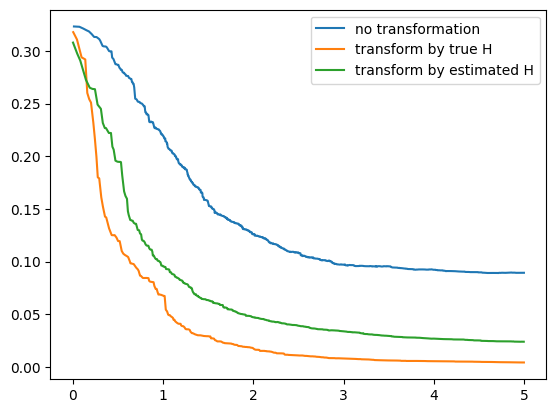

In [12]:
plt.plot(results[0][0]['times'], results[0][0]['mse'], label = 'no transformation')
plt.plot(results[1][0]['times'], results[1][0]['mse'], label = 'transform by true H')
plt.plot(results[2][0]['times'], results[2][0]['mse'], label = 'transform by estimated H')
plt.legend()

In [13]:
raw_H_estimates[4]['H'][0]

array([[0.8526, 0.5172, 0.4029, 0.1448, 0.1629],
       [0.5172, 1.3477, 0.5044, 0.528 , 0.4758],
       [0.4029, 0.5044, 0.8004, 0.1662, 0.1211],
       [0.1448, 0.528 , 0.1662, 0.8607, 0.3916],
       [0.1629, 0.4758, 0.1211, 0.3916, 0.7908]], dtype=float32)

In [14]:
H_1

array([[0.7152, 0.4339, 0.338 , 0.1215, 0.1366],
       [0.4339, 1.1306, 0.4231, 0.4429, 0.3992],
       [0.338 , 0.4231, 0.6714, 0.1394, 0.1016],
       [0.1215, 0.4429, 0.1394, 0.722 , 0.3285],
       [0.1366, 0.3992, 0.1016, 0.3285, 0.6634]], dtype=float32)

In [15]:
true_H/two_one_norm(true_H)

Array([[0.5234, 0.5234, 0.5234, 0.    , 0.    ],
       [0.5234, 1.0249, 0.5234, 0.5015, 0.5015],
       [0.5234, 0.5234, 0.5234, 0.    , 0.    ],
       [0.    , 0.5015, 0.    , 0.5015, 0.5015],
       [0.    , 0.5015, 0.    , 0.5015, 0.5015]], dtype=float32)

In [16]:
lifetime = 5

stats = []
for i in range(len(sample_range)):
    n_sim = sample_range[i]
    dist = {'n': n_sim, 'history': []}
    for trial in tqdm(range(tries)):
        history, w_trees = train(
            x_train_transformed[:n_sim, ], y_train[:n_sim, ], M, lifetime, delta
        )
        dist['history'].append([history, w_trees])
    stats.append(dist)

100%|██████████| 10/10 [00:11<00:00,  1.10s/it]


In [ ]:
raw_H_estimates = get_H_estimates(stats, x_train_transformed, y_train, M, sample_range, tries = 10)

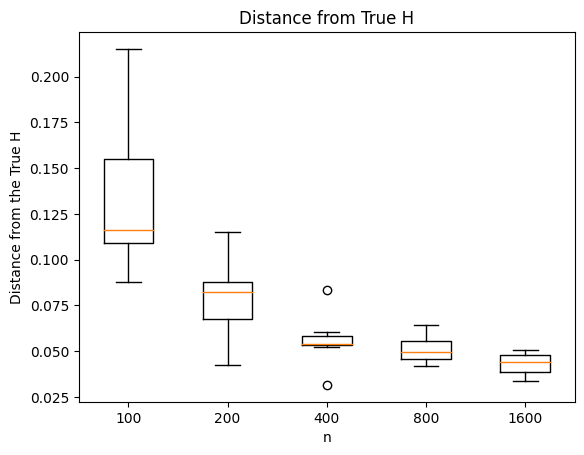

In [20]:
def get_angle_distance_1(H, truth, active, dim_in):
    return get_angle_distance(np.matmul(H_1, H), truth, active, dim_in)

plot_H_estimates(raw_H_estimates, true_H, get_angle_distance_1, sample_range, active, dim_in)

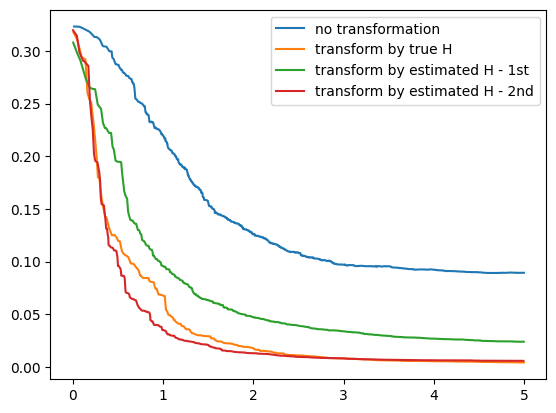

In [18]:
H_2 = raw_H_estimates[4]['H'][0]/two_one_norm(raw_H_estimates[4]['H'][0])

x_train_transformed, x_test_transformed = transform_data(H_2, x_train_transformed, x_test_transformed)
results.append(
    evaluate_all_lifetimes(x_train_transformed[:n_sim, ], 
                           y_train[:n_sim], 
                           x_test_transformed, y_test, M, lifetime_max, delta))

plt.plot(results[0][0]['times'], results[0][0]['mse'], label = 'no transformation')
plt.plot(results[1][0]['times'], results[1][0]['mse'], label = 'transform by true H')
plt.plot(results[2][0]['times'], results[2][0]['mse'], label = 'transform by estimated H - 1st')
plt.plot(results[3][0]['times'], results[3][0]['mse'], label = 'transform by estimated H - 2nd')
plt.legend()